In [41]:
from fit import fit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import latexify

In [42]:
np.random.seed(2)
n, r = 10, 2
A = np.eye(r) + .1 * np.random.randn(r, r); A = .98 * A / np.max(np.abs(np.linalg.eig(A)[0]))
C = np.random.randn(n, r)
Q = np.eye(r)
R = .1 * np.eye(n)

z = np.zeros(r)
for _ in range(500):
    x = C @ z + np.random.multivariate_normal(np.zeros(n), R)
    z = A @ z + np.random.multivariate_normal(np.zeros(r), Q)

Ztrain, Xtrain = [], []
for _ in range(100):
    x = C @ z + np.random.multivariate_normal(np.zeros(n), R)
    Ztrain.append(z)
    Xtrain.append(x)
    z = A @ z + np.random.multivariate_normal(np.zeros(r), Q)
Xtrain = np.array(Xtrain)
Ztrain = np.array(Ztrain)

z = np.zeros(r)
for _ in range(500):
    x = C @ z + np.random.multivariate_normal(np.zeros(n), R)
    z = A @ z + np.random.multivariate_normal(np.zeros(r), Q)

    Ztest, Xtest = [], []
for _ in range(500):
    x = C @ z + np.random.multivariate_normal(np.zeros(n), R)
    Ztest.append(z)
    Xtest.append(x)
    z = A @ z + np.random.multivariate_normal(np.zeros(r), Q)
Xtest = np.array(Xtest)
Ztest = np.array(Ztest)

In [43]:
Xmean = Xtrain.mean(axis=0)

Xtrain_processed = Xtrain - Xmean
Xtest_processed = Xtest - Xmean

H = 12
M = 12

# State space forecaster

In [44]:
import cvxpy as cp
z = cp.Variable((M, r))
x = cp.Parameter((M, n))
prob = cp.Problem(cp.Minimize(
    cp.sum_squares(z[1:] - z[:-1] @ A.T) + 10 * cp.sum_squares(x - z @ C.T)
))
x.value = np.zeros((M, n))
Ukf = np.zeros((M*n, r))
for i in range(M):
    for j in range(n):
        x.value = np.zeros((M, n))
        x.value[i, j] = 1.
        prob.solve(solver=cp.OSQP)
        Ukf[i*n+j,:] = z.value[-1]
Vkf = np.vstack([C @ (np.linalg.multi_dot([A]*i) if i > 1 else A) for i in range(1,H+1)]).T

In [45]:
_, _, _, Ptest, Ftest, info = fit(Xtest, H=H, M=M, niter=1, verbose=False)
np.mean(np.square(Ptest @ Ukf @ Vkf - Ftest))

10.542677531858025

# $\ell_2$ Regularized regression forecaster

In [46]:
_, _, _, Ptrain, Ftrain, info = fit(Xtrain_processed, H=H, M=M, niter=1, verbose=False)
_, _, _, Ptest, Ftest, info = fit(Xtest_processed, H=H, M=M, niter=1, verbose=False)

In [47]:
theta = np.linalg.lstsq(np.vstack([Ptrain, 0 * np.eye(Ptrain.shape[1])]), np.vstack([Ftrain, np.zeros((Ptrain.shape[1], Ftrain.shape[1]))]))[0]
np.mean(np.square(Ptest @ theta - Ftest))

/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


27.2277138499108

# Low rank forecaster

In [48]:
z, U, V, Ptrain, Ftrain, info = fit(Xtrain_processed, M=M, H=H, alpha=.1, kappa=0, niter=20, rank=20, verbose=True, l2_regularization=0)

Setting lam to 113.159.
Setting up forecaster consistency.
0 | 1287.619836746764
1 | 975.5637944097704
2 | 925.6433744339454
3 | 897.0175200271549
4 | 881.6487125214059
5 | 873.4057845223805
6 | 865.8684704283196
7 | 860.0764463814253
8 | 858.4804986117158
9 | 858.2156491764887
10 | 858.1779316800298
11 | 858.1726433692486
12 | 858.1718699505107
13 | 858.1717493029726
14 | 858.1717291494488
15 | 858.1717255350943
16 | 858.1717248723623
17 | 858.1717247471472
18 | 858.1717247257212
19 | 858.171724722951
Theta has rank 2
Time: 6.6371448040008545


In [49]:
_, _, _, Ptest, Ftest, info = fit(Xtest_processed, M=M, H=H, niter=1)
np.mean(np.square(Ptest @ U @ V - Ftest))

Setting lam to 453.903.
Setting up forecaster consistency.
0 | 2997.2559077079945
Theta has rank 1
Time: 0.1542978286743164


18.689329712094484

In [50]:
np.mean(np.square(Ftest))

50.6993855147602

In [51]:
ztest = Ptest @ U
T = np.linalg.lstsq(ztest, Ztest[M:-H+1], rcond=None)[0]

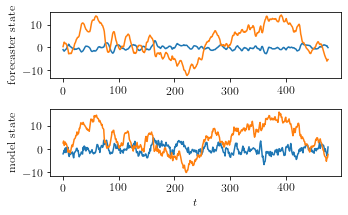

In [52]:
latexify(5)
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(ztest @ T)
ax1.set_ylabel("forecaster state")
ax2.plot(Ztest[M:-H+1])
ax2.set_xlabel("$t$")
ax2.set_ylabel("model state")
plt.tight_layout()
plt.savefig("figs/simulated_states.pdf")

In [53]:
Ahat = np.linalg.lstsq(ztest[:-1], ztest[1:], rcond=None)[0]
np.linalg.eig(Ahat)[0]

array([0.96920349+0.05084329j, 0.96920349-0.05084329j])

In [54]:
np.linalg.eig(A)[0]

array([0.79813192, 0.98      ])

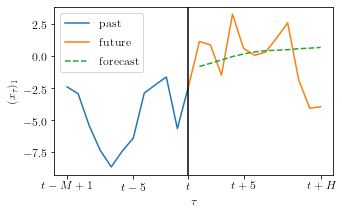

In [61]:
Fhat = Ptest @ U @ V

i = 100

latexify(5)
plt.xticks([-11, -5, 0, 5, 12], ["$t-M+1$", "$t-5$", "$t$", "$t+5$", "$t+H$"])
plt.plot(np.arange(-M+1,1), Ptest[i].reshape(M, n)[:,0], label='past')
plt.plot(np.arange(0, H+1), np.append(Ptest[i].reshape(M, n)[:,0][-1], Ftest[i].reshape(H, n)[:,0]), label='future')
plt.plot(np.arange(1,H+1), Fhat[i].reshape(H, n)[:,0], '--', label='forecast')
plt.axvline(0, c='black')
plt.legend()
plt.ylabel("$(x_\\tau)_1$")
plt.xlabel("$\\tau$")
plt.savefig("figs/simulated_forecast.pdf")

In [62]:
import torch
kappas = np.logspace(-2, 1, 10)
train = []
test = []
for kappa in kappas:
    z, U, V, Ptrain, Ftrain, info = fit(Xtrain_processed, M=M, H=H, alpha=.1, kappa=kappa, niter=20, rank=20, verbose=False)
    train.append((np.mean(np.square(Ptrain @ U @ V - Ftrain)), info["forecaster_consistency"]))
    _, _, _, Ptest, Ftest, info = fit(Xtest_processed, M=M, H=H, alpha=.1, kappa=kappa, niter=1, rank=20, verbose=False)
    test.append((np.mean(np.square(Ptest @ U @ V - Ftest)), info["fc"](torch.from_numpy(Ptest), torch.from_numpy(U), torch.from_numpy(V)).item()))

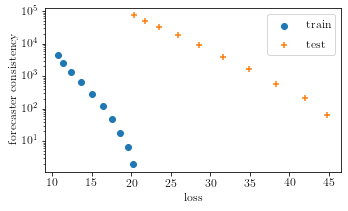

In [63]:
latexify(5)
plt.scatter(np.array(train)[:,0], np.array(train)[:,1], label='train')
plt.scatter(np.array(test)[:,0], np.array(test)[:,1], label='test', marker='+')
plt.xlabel("loss")
plt.ylabel("forecaster consistency")
plt.semilogy()
plt.legend()
plt.tight_layout()
plt.savefig("figs/simulated_consistency_vs_test_loss.pdf")

In [65]:
alphas = np.linspace(0.01, .3, 50)
test_losses = []
ranks = []
for alpha in alphas:
    z, U, V, Ptrain, Ftrain, _ = fit(Xtrain_processed, M=M, H=H, alpha=alpha, kappa=0, niter=20, rank=20, verbose=False)
    ranks.append(U.shape[1])
    _, _, _, Ptest, Ftest, _ = fit(Xtest_processed, M=M, H=H, alpha=.1, kappa=0, niter=1, rank=M*n, verbose=False)
    test_losses.append(np.mean(np.square(Ptest @ U @ V - Ftest)))

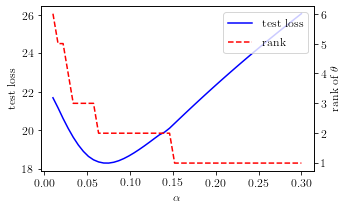

In [68]:
latexify(5)
fig, ax = plt.subplots()
l1 = ax.plot(alphas, test_losses, c='blue', label='test loss')
ax.set_ylabel("test loss")
ax2 = ax.twinx()
l2 = ax2.plot(alphas, ranks, '--', c='red', label='rank')
ax2.set_ylabel("rank of $\\theta$")
lns = l1 + l2
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=1)
ax.set_xlabel("$\\alpha$")
plt.tight_layout()
plt.savefig("figs/simulated_test_loss.pdf")

In [69]:
z, U, V, Ptrain, Ftrain, info = fit(Xtrain_processed, M=M, H=H, alpha=.1, kappa=0, niter=20, rank=20, verbose=False, l2_regularization=0)
Fhat_kappa_0 = Ptest @ U @ V

In [70]:
z, U, V, Ptrain, Ftrain, info = fit(Xtrain_processed, M=M, H=H, alpha=.1, kappa=1, niter=20, rank=20, verbose=False, l2_regularization=0)
Fhat_kappa_1 = Ptest @ U @ V

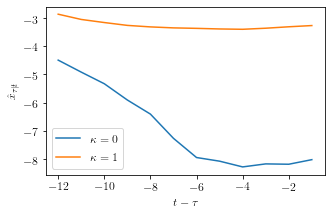

In [100]:
def get_tau_t(Fhat, tau, t):
    i = t - M
    j = tau - t - 1
    return Fhat[i, j*n:(j+1)*n]

tau = 400
x_preds = []
for t in range(tau-H, tau):
    x = get_tau_t(Fhat_kappa_0, tau, t)
    x_preds.append(x)
x_preds = np.array(x_preds)

x_preds_kappa = []
for t in range(tau-H, tau):
    x = get_tau_t(Fhat_kappa_1, tau, t)
    x_preds_kappa.append(x)
x_preds_kappa = np.array(x_preds_kappa)

from matplotlib import cm
plt.plot(np.arange(-H, 0), x_preds[:,0], label='$\\kappa=0$')
plt.plot(np.arange(-H, 0), x_preds_kappa[:,0], label='$\\kappa=1$')
plt.xlabel("$t-\\tau$")
plt.legend()
plt.ylabel("$\\hat x_{\\tau \\mid t}$")
plt.savefig("figs/simulated_consistency.pdf")